In [1]:
from pathlib import Path
import re
import time
from functools import partial

import pandas as pd
import lucene
import matplotlib.pyplot as plt

from src.helpers import process_query_results
from src.database import make_database, get_vocabulary
from src.query import query_database, fuzzy_query_database
from src.evaluation import map_at_k, mar_at_k, retrieve_top_k_docs
from src.analyzer import StemmingAnalyzer, WordLevelNGramAnalyzer


In [2]:
base_path = Path("/root/data/")
base_small_doc_path = base_path / "full_docs_small"
base_large_doc_path = base_path / "full_docs"

small_docs = {int(re.search(r'\d+', doc_path.name).group()): doc_path for doc_path in base_small_doc_path.glob("*.txt")}
large_docs = {int(re.search(r'\d+', doc_path.name).group()): doc_path for doc_path in base_large_doc_path.glob("*.txt")}

small_queries = pd.read_csv(base_path / "dev_small_queries - dev_small_queries.csv", index_col="Query number").to_dict()["Query"]
small_query_results = pd.read_csv(base_path / "dev_query_results_small.csv", index_col="Query_number")
small_query_results = process_query_results(small_queries, small_query_results)

large_queries = pd.read_csv(base_path / "dev_queries.tsv", delimiter="\t", index_col="Query number").to_dict()["Query"]
large_query_results = pd.read_csv(base_path / "dev_query_results.csv", index_col="Query_number")
large_query_results = process_query_results(large_queries, large_query_results)

test_queries = pd.read_csv(base_path / "queries.csv", delimiter="\t", index_col="Query number").to_dict()["Query"]




In [3]:
# Calculate lengths of each query
short_queries = {q_id: q for q_id, q in large_queries.items() if len(q) <= 50}

In [4]:
lucene.initVM()

In [10]:

index_dir = "/root/index/large"
output_dir = "/root/pylucene/results"
similarity = "BM25"
analyzer = None
fuzziness = 1

In [5]:
start_time = time.time()
make_database(doc_paths=small_docs, index_directory=index_dir, similarity=similarity, custom_analyzer=analyzer, 
              store_original=False)
end_time = time.time()

#vocab_size = len(get_vocabulary(index_dir=index_dir))
#print(f"Done after: {end_time - start_time:.2f}s with vocab size: {vocab_size}")

Indexing documents: 100%|██████████████████████████████████████████████████████████████████| 1557/1557 [00:01<00:00, 1532.99it/s]


In [6]:
results = query_database(index_directory=index_dir, query_str="Milestones", top_k=5)
print(results)

[(632, 4.612922668457031), (2, 4.190954208374023)]


In [5]:
k_values = [1, 3, 5, 10]
# query_function = partial(query_database, similarity=similarity, custom_analyzer=analyzer)
query_function = partial(fuzzy_query_database, similarity=similarity, custom_analyzer=analyzer, fuzziness=fuzziness)



for k in k_values:
    map_k = map_at_k(small_queries, small_query_results, index_dir, k, query_function=query_function)
    mar_k = mar_at_k(small_queries, small_query_results, index_dir, k, query_function=query_function)
    print(f"MAP@{k}: {map_k}")
    print(f"MAR@{k}: {mar_k}")

Processing queries for MAP@K=1:  19%|██████████▉                                                | 46/248 [00:01<00:06, 30.89it/s]


KeyboardInterrupt: 

In [7]:
query_function = partial(fuzzy_query_database, similarity=similarity, custom_analyzer=analyzer, fuzziness=fuzziness)

def calculate_fuzzy(metric, fuzziness, k):
    query_function = partial(fuzzy_query_database, similarity=similarity, custom_analyzer=analyzer, fuzziness=fuzziness)

    if metric == "MAP":
        return map_at_k(short_queries, large_query_results, index_dir, k, query_function=query_function)
    elif metric == "MAR":
        return mar_at_k(short_queries, large_query_results, index_dir, k, query_function=query_function)
    else:
        raise ValueError(f"{metric} is no correct metric.")

    
k_values = [1, 3, 5, 10]
fuzziness = [0, 1, 2]

map_results = {}
mar_results = {}

# Generating simulated MAP and MAR values for each (k, fuzziness) combination.
for k in k_values:
    map_results[k] = [calculate_fuzzy("MAP", f, k) for f in fuzziness]
    mar_results[k] = [calculate_fuzzy("MAR", f, k) for f in fuzziness]

Processing queries for MAR@K=10: 100%|███████████████████████████████████████████████████████| 4732/4732 [06:11<00:00, 12.75it/s]


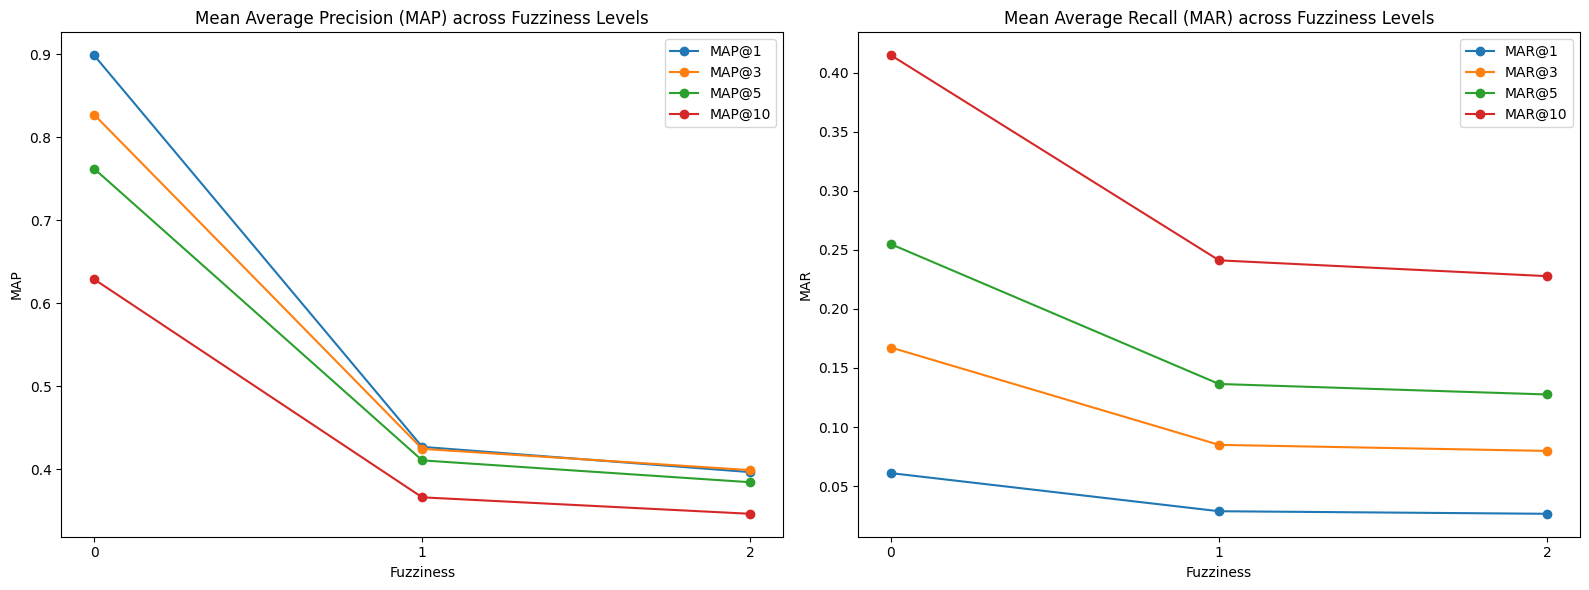

In [9]:
save_path = "/root/pylucene/results/fuzziness.png"

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAP plot
for k in k_values:
    axes[0].plot(fuzziness, map_results[k], marker='o', label=f'MAP@{k}')
axes[0].set_xlabel('Fuzziness')
axes[0].set_ylabel('MAP')
axes[0].set_title('Mean Average Precision (MAP) across Fuzziness Levels')
axes[0].set_xticks(fuzziness)  # Set x-axis to display only whole numbers
axes[0].legend()

# MAR plot
for k in k_values:
    axes[1].plot(fuzziness, mar_results[k], marker='o', label=f'MAR@{k}')
axes[1].set_xlabel('Fuzziness')
axes[1].set_ylabel('MAR')
axes[1].set_title('Mean Average Recall (MAR) across Fuzziness Levels')
axes[1].set_xticks(fuzziness)  # Set x-axis to display only whole numbers
axes[1].legend()

plt.tight_layout()
fig.savefig(save_path)

In [ ]:
k = 10
query_function = partial(query_database, similarity=similarity, custom_analyzer=analyzer)

results = retrieve_top_k_docs(test_queries, index_directory=index_dir, query_function=query_function, k=k)

results = [(q_id, doc_id) for q_id, doc_ids in results.items() for doc_id in doc_ids]
pd.DataFrame(sorted(results, key=lambda x: x[0]), columns=["Query_number", "doc_number"]).to_csv(Path(output_dir)/"results.csv", index=False)

Retrieving top-10 documents:  90%|████████████████████████████████████████████████████▏     | 5213/5793 [00:27<00:02, 205.62it/s]

In [ ]:
get_vocabulary(index_dir)

# 